# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

> NOTE: If you're running this locally - please skip this step.

In [1]:
#!pip install -qU langchain langchain_openai langchain-community langgraph arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.4/412.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [5]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE6 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.
> Usig 2 tools:
>     Websearch from Tavily 
>     ArxivQueryRun

> NOTE: Each tool in our toolbelt should be a method.

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [8]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [9]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?
> Tools are bound to the model using model this make the model know about the tools that are available to it. To determine which tools to use, the model will make decision based on the understanding of the query. If the model determine that it needs to use a tool to carry out the action, it will execute the specific tool from the tool_belt. The results of the tool execution are passed back to the model and include a tool_calls parameter in its response.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [10]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [11]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [12]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [13]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [14]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [15]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [17]:
compiled_graph = uncompiled_graph.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?
- By default, recursion limit is 25 steps reached without hitting a stop condition ref: https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/low_level.md#recursion-limit

If not, how could we impose a limit to the number of cycles?
- The rescursion limit can be set on any graph at runtime, and is passed to .invoke(inputs, config={"recursion_limit": 5})



## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [31]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates", config={"recursion_limit":10}):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w9Mr6hHzK9MWgznmpBGYPPm0', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 162, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_a1102cf978', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dc4b9007-f703-4b20-bf4e-2ebcd09dad42-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of the Winnipeg Jets'}, 'id': 'call_w9Mr6hHzK9MWgznmpBGYPPm0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 2

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [32]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ou4O4WpndhiBF2CsRhmrXctc', 'function': {'arguments': '{"query":"QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 178, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_a1102cf978', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-18ade660-6289-48a8-b27d-9e0823d83814-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_ou4O4WpndhiBF2CsRhmrXctc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 178, 'output_tokens': 17, 'total_tokens': 195, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

The agent synthesised all the information into a clear response. This sequence shows how the LangGraph pipeline:

Processes the initial request -> Makes tool calls to gather information -> Processes the tool results -> Makes additional tool calls as needed -> Finally synthesises all the information into a coherent response as below

1. First Agent: The agent decided to first search for QLoRA papers on Arxiv.
2. First Action: The Arxiv tool returned the paper information including the authors
3. Second Agent: The agent decided to search for each author's latest tweets
4. Second Action: Tavily tool returned search results for each author's tweets




# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [39]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | compiled_graph | parse_output

In [40]:
agent_chain.invoke({"question" : "What is RAG?"})

"**RAG** stands for **Retrieval-Augmented Generation**. It is an approach in natural language processing (NLP) that combines two main components:\n\n1. **Retrieval**: The system first retrieves relevant documents or pieces of information from a large database or knowledge base, based on the user's query.\n2. **Generation**: Then, a language model (like GPT) uses the retrieved information to generate a more accurate, informed, and contextually relevant response.\n\n### How RAG Works\n\n- When a user asks a question, the system searches (retrieves) for relevant documents or passages.\n- These retrieved texts are then provided as additional context to a generative language model.\n- The language model uses both the user’s question and the retrieved information to generate a final answer.\n\n### Why Use RAG?\n\n- **Improved Accuracy**: By grounding responses in real, up-to-date information, RAG models can provide more factual and reliable answers.\n- **Scalability**: RAG can access vast ex

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

questions = [
    "What is the main innovation in the QLoRA paper?",
    "What is the purpose of using 4-bit quantization in QLoRA?",
    "What is the Guanaco model mentioned in the QLoRA paper?",
    "What are the key components of a RAG system?",
    "What is the significance of double quantization in QLoRA?"
]

answers = [
    {"must_mention": ["memory", "efficiency", "finetuning"]},
    {"must_mention": ["memory", "reduction", "performance"]},
    {"must_mention": ["model", "family", "performance"]},
    {"must_mention": ["retrieval", "generation", "context"]},
    {"must_mention": ["quantization", "constants", "memory"]}
]

In [25]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [41]:
from langsmith import Client

client = Client()

dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

{'example_ids': ['08c991bf-c85b-436f-8f1d-2a7915f16236',
  'f9816070-915f-4734-9bc4-303cf522c3e0',
  'a6d6f636-e2a1-4658-80c9-51b09c5deceb',
  'b1ab9693-daf9-4916-a0ed-63a9f0c5272b',
  '47bac0de-f249-4cdd-b0ce-0aceba92275b'],
 'count': 5}

#### ❓ Question #3:

How are the correct answers associated with the questions?
> In the code, the questions and answers are associated through their position in their respective lists. The first question "What optimizer is used in QLoRA?" is associated with the first answer {"must_mention" : ["paged", "optimizer"]}, The second question "What data type was created in the QLoRA paper?" is associated with the second answer {"must_mention" : ["NF4", "NormalFloat"]} and so on.
>This means:
>questions[0] corresponds to answers[0]
>questions[1] corresponds to answers[1]


> NOTE: Feel free to indicate if this is problematic or not
> While the current format enables straightforward indexing to match questions with their expected answers, it suffers from two significant drawbacks: the lack of explicit relationships between questions and answers, and the positional dependency issue. If the questions or answers are accidentally reordered, the associations will break. A more robust approach would be to explicitly pair each question with its corresponding answer, for example:

```json
{ 
      "question": "What optimizer is used in QLoRA?",
        "answer": {
            "must_mention": ["paged", "optimizer"],
            "context": "The paged optimizer is used to manage memory spikes during training"
      }
}
```

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [42]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?
> Semantic Similarity instead of using exact word matches, use embeddings to check semantic similarity. This would catch synonyms and related terms (e.g., "memory" vs "RAM" vs "storage"). 

> Pattern matching using REGEX If the evaluation has to check on the exact word, this would help prevent the mismatch of capitalisation vs non-capitalisation. Support flexible formatting (e.g., "4-bit" vs "four-bit" vs "4 bit")

> Negative Example. Add technical terms that shouldn't appear in the answer but might be closely related to another paper. This prevents confusion with similar concepts from related papers. Add validation for common misconceptions or closely related but incorrect terms.

> NOTE: Alternatively you can suggest where gaps exist in this method.

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [43]:
experiment_results = client.evaluate(
    agent_chain,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"RAG Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'RAG Pipeline - Evaluation - 7a39-c0708c74' at:
https://smith.langchain.com/o/1cfd9d14-6eca-5ab6-8118-dc842886f98a/datasets/78e7f83e-5652-464c-be9b-c493e289f762/compare?selectedSessions=ad7218f7-6dd2-4e57-9623-1146e400c235




0it [00:00, ?it/s]

In [45]:
experiment_results

,inputs.question,outputs.output,error,reference.must_mention,feedback.must_mention,execution_time,example_id,id
0,What is the significance of double quantizatio...,**Double quantization** is a key technique use...,None,"[quantization, constants, memory]",True,7.248772,08c991bf-c85b-436f-8f1d-2a7915f16236,df7a9645-3e1c-4125-93af-f6d318e532c0
1,What are the key components of a RAG system?,A **Retrieval-Augmented Generation (RAG)** sys...,None,"[retrieval, generation, context]",True,8.859287,47bac0de-f249-4cdd-b0ce-0aceba92275b,37d3f3d2-5d20-45f8-b97d-0a755f20a5d5
2,What is the purpose of using 4-bit quantizatio...,The purpose of using **4-bit quantization in Q...,None,"[memory, reduction, performance]",False,6.321464,a6d6f636-e2a1-4658-80c9-51b09c5deceb,f3a5fa90-10d9-4fd4-adad-3500bb1f56a0
3,What is the Guanaco model mentioned in the QLo...,The **Guanaco model** is an open-source large ...,None,"[model, family, performance]",True,7.524777,b1ab9693-daf9-4916-a0ed-63a9f0c5272b,7599bdc5-8f2b-4eab-901a-49ea1a9300c6
4,What is the main innovation in the QLoRA paper?,The main innovation in the QLoRA paper is an e...,None,"[memory, efficiency, finetuning]",False,7.697411,f9816070-915f-4734-9bc4-303cf522c3e0,bfa414e0-8b37-4f7d-82a3-a2f9d831891e


## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [44]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE

1. This creates a new StateGraph called graph_with_helpfulness_check with AgentState as the state type 
2. Add the agent node that will use the call_model function
3. Adds the action node that will handle tool calls


In [47]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE
1. Set entry point by specifying that agent node is the starting point of the graph execution

In [48]:
graph_with_helpfulness_check.set_entry_point("agent")


##### YOUR MARKDOWN HERE

```tool_call_or_helpful()``` is a routing mechanism in Langgraph to determine the next step in the agent and action flow. 

It checks for tool calls by looking at the last message in the conversation ```state["messages"][-1]``` if the message contains tool calls then route to the action node to execute those tools. It then prevents infinite back and forth by monitoring conversation length to not be more than 10 messages.

It then sets ```prompt_template``` for evaluating response helpfulness with Y and N. It uses GPT-4 to check if the response is helpful (Y) or unhelpful (N). If not helpful, it will continue processing. This is executed through the processing pipeline using LCEL ```helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()```

In [58]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

This function controls conversation flow by evaluating responses and managing tool usage. Check Tool Calls → Check Length → Evaluate Helpfulness → Make Decision

1. **Tool Calls** → "action"
   - If last message needs tools
   - Routes to action node

2. **Length Check** → "END"
   - If conversation > 10 messages
   - Prevents infinite loops

3. **Helpfulness Check** → "end" or "continue"
   - Uses GPT-4 to evaluate response quality
   - Y = helpful → end conversation
   - N = unhelpful → continue processing

Determines the next step in the conversation:
- Execute tools
- End conversation
- Or continue for better answer


##### YOUR MARKDOWN HERE

This adds contiditonal edge to the graph_with_helpfulness_check, defininf how to conversation can flow based on the ```tool_call_or_helpful()``` 

All the routes start from agent node -> tool_call_or_helpful decides one of these 3 scenarios:
1. continue -> agent
2. action -> action
3. end -> END

This creates a flexible conversation flow where:
- The agent can keep trying to improve answers
- Tools can be used when needed
- The conversation can end when satisfied

In [69]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `tool_call_or_helpful` already exists for node `agent`

##### YOUR MARKDOWN HERE

This adds a direct edge from the action node back to the agent node. It creates a return path after toold are exeted in the action node. Allows the agent to process the tool results

Agent -> Tools -> Back to Agent which allows iterative improvement 

This edge is crucial because it:
- Allows the agent to process tool results
- Enables multiple tool-use iterations
- Creates a complete conversation loop
- Lets the agent improve answers based on tool findings


In [51]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### YOUR MARKDOWN HERE

This line takes all the nodes and edges we've defined and complied them into an exectuable graph

In [65]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

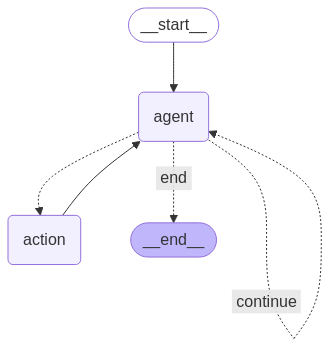

In [67]:
agent_with_helpfulness_check

##### YOUR MARKDOWN HERE

Runs the agent
Shows the conversation flow
Displays how the agent processes the questions
Demonstrates the interaction between nodes

In [53]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Bnb48AC7ga3brqOjYEkp28m7', 'function': {'arguments': '{"query": "LoRA machine learning definition"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_C4b4fBLxYfK2F23OyOdjdvaB', 'function': {'arguments': '{"query": "Tim Dettmers machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_QkAbUR2LRkgcRmAUoGbUJhVr', 'function': {'arguments': '{"query": "Attention mechanism in machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 177, 'total_tokens': 261, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_finger

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [54]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [60]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

**Prompt engineering** is the practice of designing and refining prompts (the input text or instructions) given to large language models (LLMs) like GPT-3, GPT-4, and similar AI systems, to achieve desired outputs or behaviors. It involves crafting questions, instructions, or context in a way that guides the AI to produce more accurate, relevant, or creative responses.

### What is Prompt Engineering?
- **Definition:** The art and science of creating effective prompts to interact with AI models.
- **Purpose:** To maximize the usefulness, accuracy, and reliability of AI-generated outputs.
- **Techniques:** Includes using specific instructions, examples (few-shot learning), constraints, or formatting to steer the model.

### When Did Prompt Engineering "Break Onto the Scene"?
Prompt engineering became a recognized and widely discussed concept with the public release and popularization of large language models, especially OpenAI’s GPT-3 in June 2020. While earlier models like GPT-2 (2019)